This is adapted from the R code for the Pixel Forecast Manuscript evaluation. Datasets are large and need to be processed with more memory than my desktop has.

* Author: Max Beal
* Date: 7/24/25

### Define python version of metric functions

In [130]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, mean_absolute_error, r2_score
from joblib import Parallel, delayed


def compute_metrics_for_group(group_key, group_df):
    x, y = group_key
    
    def compute_confusion_metrics(y_true, y_pred):
        labels = [0, 1]
        try:
            cm = confusion_matrix(y_true, y_pred, labels=labels)
            tn, fp, fn, tp = cm.ravel()
        except:
            tn = fp = fn = tp = 0
            if all(y_true == 0) and all(y_pred == 0):
                tn = len(y_true)
            elif all(y_true == 1) and all(y_pred == 1):
                tp = len(y_true)
        accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else np.nan
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan
        specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan
        return accuracy, sensitivity, specificity
    
    # Calculate metrics
    acc_al1, sen_al1, spe_al1 = compute_confusion_metrics(group_df['Bloom_observed'], group_df['Bloom_predicted'])
    accnull_al1, sennull_al1, spenull_al1 = compute_confusion_metrics(group_df['Bloom_observed'], group_df['Bloom_LTA_al1'])
    
    acc_al2, sen_al2, spe_al2 = compute_confusion_metrics(group_df['Bloom_observed_al2'], group_df['Bloom_predicted_al2'])
    accnull_al2, sennull_al2, spenull_al2 = compute_confusion_metrics(group_df['Bloom_observed_al2'], group_df['Bloom_LTA_al2'])
    
    try:
        rsq = r2_score(group_df['chl_observed'], group_df['chl_predicted'])
    except:
        rsq = np.nan
    
    try:
        rsqnull = r2_score(group_df['chl_observed'], group_df['chl_LTA'])
    except:
        rsqnull = np.nan
    

    mae = mean_absolute_error(group_df['chl_observed'], group_df['chl_predicted'])
    maenull = mean_absolute_error(group_df['chl_observed'], group_df['chl_LTA'])
    
    acc_imp_al1 = acc_al1 - accnull_al1 if (not np.isnan(acc_al1) and not np.isnan(accnull_al1)) else np.nan
    sen_imp_al1 = sen_al1 - sennull_al1 if (not np.isnan(sen_al1) and not np.isnan(sennull_al1)) else np.nan
    spe_imp_al1 = spe_al1 - spenull_al1 if (not np.isnan(spe_al1) and not np.isnan(spenull_al1)) else np.nan
    
    acc_imp_al2 = acc_al2 - accnull_al2 if (not np.isnan(acc_al2) and not np.isnan(accnull_al2)) else np.nan
    sen_imp_al2 = sen_al2 - sennull_al2 if (not np.isnan(sen_al2) and not np.isnan(sennull_al2)) else np.nan
    spe_imp_al2 = spe_al2 - spenull_al2 if (not np.isnan(spe_al2) and not np.isnan(spenull_al2)) else np.nan
    
    mae_imp = mae - maenull if (not np.isnan(mae) and not np.isnan(maenull)) else np.nan
    r2_imp = rsq - rsqnull if (not np.isnan(rsq) and not np.isnan(rsq)) else np.nan
    
    return {
        'x': x,
        'y': y,
        'Accuracy_AL1': acc_al1,
        'Sensitivity_AL1': sen_al1,
        'Specificity_AL1': spe_al1,
        'AccuracyNull_AL1': accnull_al1,
        'SensitivityNull_AL1': sennull_al1,
        'SpecificityNull_AL1': spenull_al1,
        'Accuracy_AL2': acc_al2,
        'Sensitivity_AL2': sen_al2,
        'Specificity_AL2': spe_al2,
        'AccuracyNull_AL2': accnull_al2,
        'SensitivityNull_AL2': sennull_al2,
        'SpecificityNull_AL2': spenull_al2,
        'Rsquared': rsq,
        'MAE': mae,
        'MAENull': maenull,
        'Acc_imp_AL1': acc_imp_al1,
        'Acc_imp_AL1_bool': int(acc_imp_al1>0),
        'Sen_imp_AL1': sen_imp_al1,
        'Sen_imp_AL1_bool': int(sen_imp_al1>0),
        'Spe_imp_AL1': spe_imp_al1,
        'Spe_imp_AL1_bool': int(spe_imp_al1>0),
        'Acc_imp_AL2': acc_imp_al2,
        'Acc_imp_AL2_bool': int(acc_imp_al2>0),
        'Sen_imp_AL2': sen_imp_al2,
        'Sen_imp_AL2_bool': int(sen_imp_al2>0),
        'Spe_imp_AL2': spe_imp_al2,
        'Spe_imp_AL2_bool': int(spe_imp_al2>0),
        'MAE_imp': mae_imp,
        'MAE_imp_bool': int(mae_imp>0),
        'Rsquare_imp': r2_imp,
        'Rsquare_imp_bool': int(r2_imp>0)
    }

def evaluate_continuous_parallel(df):

    grouped = list(df.groupby(['x', 'y']))
    
    # Run in parallel
    results = Parallel(n_jobs=-1)(delayed(compute_metrics_for_group)(key, group) for key, group in grouped)
    
    return pd.DataFrame(results)




### Run in parallel for each pixel

In [164]:
df1['COMID']

KeyError: 'COMID'

In [151]:
# Usage:
import pandas as pd


path = '/Users/mbeal/Desktop/Data/Forecast/Folds/'
files = [path+'RF_folds_all.csv', path+"BRMS_folds_all.csv", path+"CLSTM_folds_all.csv"]
savename = ["rf_metrics_parallel.csv","brms_metrics_parallel.csv","clstm_metrics_parallel.csv"]
for i, file in enumerate(files):
    print(file)
    readcols = ['x', 'y', 'chl_predicted', 'chl_LTA', 'Week','error', 'chl_observed', 'Bloom_predicted','Bloom_observed','Bloom_LTA_al1','Time','Bloom_observed_al2','Bloom_predicted_al2','Bloom_LTA_al1','Bloom_LTA_al2']
    df1 = pd.read_csv(file,usecols=readcols)
    df1 = df1.dropna()
    if savename[i]=="brms_metrics_parallel.csv":
        df1['chl_predicted'] = np.log10(df1['chl_predicted'])
        df1 = df1[~np.isinf(df1['chl_predicted'])]
    #Calculating Metrics
    print("calculating metrics")
    metrics = evaluate_continuous_parallel(df1)
    metrics.to_csv(savename[i], index=False)

/Users/mbeal/Desktop/Data/Forecast/Folds/RF_folds_all.csv
calculating metrics


/Users/mbeal/Desktop/Projects/venvanalysis/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/mbeal/Desktop/Projects/venvanalysis/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/mbeal/Desktop/Projects/venvanalysis/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/mbeal/Desktop/Projects/venvanalysis/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/mbeal/Desktop/Projects/venvanalysis/lib/python3.1

/Users/mbeal/Desktop/Data/Forecast/Folds/BRMS_folds_all.csv
calculating metrics


/Users/mbeal/Desktop/Projects/venvanalysis/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/mbeal/Desktop/Projects/venvanalysis/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/mbeal/Desktop/Projects/venvanalysis/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/mbeal/Desktop/Projects/venvanalysis/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/mbeal/Desktop/Projects/venvanalysis/lib/python3.1

/Users/mbeal/Desktop/Data/Forecast/Folds/CLSTM_folds_all.csv
calculating metrics


/Users/mbeal/Desktop/Projects/venvanalysis/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/mbeal/Desktop/Projects/venvanalysis/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/mbeal/Desktop/Projects/venvanalysis/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/mbeal/Desktop/Projects/venvanalysis/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/mbeal/Desktop/Projects/venvanalysis/lib/python3.1

Metrics for lead times

In [154]:
# Usage:
import pandas as pd

path = '/Users/mbeal/Desktop/Data/Forecast/Leadtimes/'
files = [path+'RF_folds2lead.csv', path+"RF_folds4lead.csv"]
savename = ["rf2_metrics_parallel.csv","rf4_metrics_parallel.csv"]
for i, file in enumerate(files):
    print(file)
    readcols = ['x', 'y', 'chl_predicted', 'chl_LTA', 'Week','error', 'chl_observed', 'Bloom_predicted','Bloom_observed','Bloom_LTA_al1','Time','Bloom_observed_al2','Bloom_predicted_al2','Bloom_LTA_al1','Bloom_LTA_al2']
    df1 = pd.read_csv(file,usecols=readcols)
    df1 = df1.dropna()

    #Calculating Metrics
    print("calculating metrics")
    metrics = evaluate_continuous_parallel(df1)
    metrics.to_csv(savename[i], index=False)

/Users/mbeal/Desktop/Data/Forecast/Leadtimes/RF_folds2lead.csv
calculating metrics


/Users/mbeal/Desktop/Projects/venvanalysis/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/mbeal/Desktop/Projects/venvanalysis/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/mbeal/Desktop/Projects/venvanalysis/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/mbeal/Desktop/Projects/venvanalysis/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/mbeal/Desktop/Projects/venvanalysis/lib/python3.1

/Users/mbeal/Desktop/Data/Forecast/Leadtimes/RF_folds4lead.csv
calculating metrics


/Users/mbeal/Desktop/Projects/venvanalysis/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/mbeal/Desktop/Projects/venvanalysis/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/mbeal/Desktop/Projects/venvanalysis/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/mbeal/Desktop/Projects/venvanalysis/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/mbeal/Desktop/Projects/venvanalysis/lib/python3.1

In [162]:
metrics

,x,y,Accuracy_AL1,Sensitivity_AL1,Specificity_AL1,AccuracyNull_AL1,SensitivityNull_AL1,SpecificityNull_AL1,Accuracy_AL2,Sensitivity_AL2,...,Acc_imp_AL2,Acc_imp_AL2_bool,Sen_imp_AL2,Sen_imp_AL2_bool,Spe_imp_AL2,Spe_imp_AL2_bool,MAE_imp,MAE_imp_bool,Rsquare_imp,Rsquare_imp_bool
0,977853,899076,0.958678,0.000000,0.974790,0.983471,0.000000,1.000000,1.000000,NaN,...,0.000000,0,NaN,0,0.000000,0,1.706132,1,-1.403272,0
1,978153,898776,0.936709,0.000000,0.969432,0.957806,0.000000,0.991266,0.995781,0.000000,...,0.000000,0,0.000000,0,0.000000,0,1.640159,1,-0.623116,0
2,978153,899076,0.953586,0.000000,0.978355,0.974684,0.000000,1.000000,0.995781,0.000000,...,0.000000,0,0.000000,0,0.000000,0,1.551084,1,-0.895400,0
3,980553,873876,0.968872,NaN,0.968872,1.000000,NaN,1.000000,1.000000,NaN,...,0.000000,0,NaN,0,0.000000,0,1.853801,1,-138.004108,0
4,980853,873876,0.966165,NaN,0.966165,1.000000,NaN,1.000000,1.000000,NaN,...,0.000000,0,NaN,0,0.000000,0,1.762145,1,-359.172985,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23269,1550253,364476,0.726277,0.860000,0.564516,0.576642,0.586667,0.564516,0.890511,0.386364,...,0.062044,1,0.386364,1,0.000000,0,-2.670117,0,0.527119,1
23270,1550553,364176,0.713768,0.885906,0.511811,0.565217,0.657718,0.456693,0.829710,0.327869,...,0.061594,1,0.295082,1,-0.004651,0,-3.119848,0,0.522019,1
23271,1551153,363876,0.700000,0.854167,0.523810,0.588889,0.673611,0.492063,0.877778,0.360000,...,0.096296,1,0.320000,1,0.045455,1,-3.247623,0,0.545903,1
23272,1551453,363576,0.753676,0.924855,0.454545,0.584559,0.774566,0.252525,0.779412,0.435897,...,0.106618,1,0.358974,1,0.005155,1,-3.707263,0,0.511082,1


In [165]:
metrics = pd.read_csv("rf_metrics_parallel.csv")

means = metrics.mean()
medians = metrics.median()

# Calculate IQR
i75 = metrics.quantile(0.75)
i25 = metrics.quantile(0.25)

# Combine results in one DataFrame
summary = pd.DataFrame({
    'Means': means,
    'Median': medians,
    '25': i25,
    '75':i75
})

print(summary.map('{:.2f}'.format))

                            Means      Median          25          75
x                      1473787.62  1505253.00  1438653.00  1515753.00
y                       605287.70   563376.00   548976.00   652476.00
Accuracy_AL1                 0.87        0.87        0.84        0.90
Sensitivity_AL1              0.57        0.57        0.41        0.72
Specificity_AL1              0.85        0.91        0.87        0.95
AccuracyNull_AL1             0.83        0.85        0.79        0.88
SensitivityNull_AL1          0.39        0.36        0.22        0.53
SpecificityNull_AL1          0.83        0.91        0.88        0.94
Accuracy_AL2                 0.92        0.94        0.90        0.96
Sensitivity_AL2              0.24        0.16        0.08        0.29
Specificity_AL2              0.93        0.99        0.98        1.00
AccuracyNull_AL2             0.89        0.92        0.88        0.95
SensitivityNull_AL2          0.17        0.09        0.00        0.21
SpecificityNull_AL2 

In [194]:
metrics1

,x,y,Accuracy_AL1,Sensitivity_AL1,Specificity_AL1,AccuracyNull_AL1,SensitivityNull_AL1,SpecificityNull_AL1,Accuracy_AL2,Sensitivity_AL2,...,Acc_imp_AL2,Acc_imp_AL2_bool,Sen_imp_AL2,Sen_imp_AL2_bool,Spe_imp_AL2,Spe_imp_AL2_bool,MAE_imp,MAE_imp_bool,Rsquare_imp,Rsquare_imp_bool
0,977853,899076,0.983673,0.000000,1.000000,0.983673,0.000000,1.000000,1.000000,NaN,...,0.000000,0,NaN,0,0.000000,0,1.002824,1,-0.301574,0
1,978153,898776,0.962500,0.000000,0.995690,0.958333,0.000000,0.991379,0.995833,0.000000,...,0.000000,0,0.000000,0,0.000000,0,1.202990,1,-0.123050,0
2,978153,899076,0.970833,0.000000,0.995726,0.975000,0.000000,1.000000,0.995833,0.000000,...,0.000000,0,0.000000,0,0.000000,0,1.040480,1,-0.181854,0
3,980553,873876,1.000000,NaN,1.000000,1.000000,NaN,1.000000,1.000000,NaN,...,0.000000,0,NaN,0,0.000000,0,1.219600,1,-14.495460,0
4,980853,873876,1.000000,NaN,1.000000,1.000000,NaN,1.000000,1.000000,NaN,...,0.000000,0,NaN,0,0.000000,0,1.164098,1,-29.959022,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23286,1550253,364476,0.754513,0.841060,0.650794,0.599278,0.642384,0.547619,0.880866,0.386364,...,0.050542,1,0.386364,1,-0.012876,0,-3.847899,0,0.680683,1
23287,1550553,364176,0.745520,0.881579,0.582677,0.573477,0.677632,0.448819,0.827957,0.370968,...,0.068100,1,0.338710,1,-0.009217,0,-4.181298,0,0.662931,1
23288,1551153,363876,0.736264,0.897260,0.551181,0.630037,0.753425,0.488189,0.879121,0.400000,...,0.102564,1,0.380000,1,0.040359,1,-4.114271,0,0.670421,1
23289,1551453,363576,0.781818,0.920455,0.535354,0.578182,0.767045,0.242424,0.800000,0.500000,...,0.130909,1,0.397436,1,0.025381,1,-5.127732,0,0.679966,1


,x,y,AccuracyL1,AccuracyL2,AccuracyL4,Decline_1_2,Decline_2_4,COMID
0,977853,899076,0.000000,0.000000,-0.024793,False,True,2241295
1,977853,899076,0.000000,0.000000,-0.024793,False,True,2241295
2,977853,899076,0.000000,0.000000,-0.024793,False,True,2241295
3,977853,899076,0.000000,0.000000,-0.024793,False,True,2241295
4,977853,899076,0.000000,0.000000,-0.024793,False,True,2241295
...,...,...,...,...,...,...,...,...
8723900,1551453,363876,0.113553,0.136029,0.137037,False,False,86706
8723901,1551453,363876,0.113553,0.136029,0.137037,False,False,86706
8723902,1551453,363876,0.113553,0.136029,0.137037,False,False,86706
8723903,1551453,363876,0.113553,0.136029,0.137037,False,False,86706


In [274]:
metrics1 = pd.read_csv("rf_metrics_parallel.csv")
metrics2 = pd.read_csv("rf2_metrics_parallel.csv")
metrics3 = pd.read_csv("rf4_metrics_parallel.csv")

#lakes = pd.read_csv("/Users/mbeal/Desktop/Writing/pixel_forecast_ms/florida_data_spatial.csv")

ac1 = metrics1[["x","y","Accuracy_AL1"]]
ac2 = metrics2[["x","y","Accuracy_AL1"]]
ac4 = metrics3[["x","y","Accuracy_AL1"]]

'''ac1 = ac1.rename(columns = {"Acc_imp_AL1":"AccuracyL1"})
ac2 = ac2.rename(columns = {"Acc_imp_AL1":"AccuracyL2"})
ac4 = ac4.rename(columns = {"Acc_imp_AL1":"AccuracyL4"})'''

ac1 = ac1.rename(columns = {"Accuracy_AL1":"AccuracyL1"})
ac2 = ac2.rename(columns = {"Accuracy_AL1":"AccuracyL2"})
ac4 = ac4.rename(columns = {"Accuracy_AL1":"AccuracyL4"})

acleads = pd.merge(ac1,ac2)
acleads = pd.merge(acleads,ac4)

acleads = pd.merge(acleads,lakes[['x','y','COMID']])

acleads['Decline_1_2'] = (acleads['AccuracyL2'] - acleads['AccuracyL1']) < 0

acleads['Decline_2_4'] = (acleads['AccuracyL4'] - acleads['AccuracyL2']) < 0

cm = pd.crosstab(acleads['Decline_1_2'], acleads['Decline_2_4'], rownames=['Decline_1_2'], colnames=['Decline_2_4'])
print(cm)
cm_percent = cm / cm.values.sum() * 100
print(cm_percent.round(2))

acleads['num_declines'] = acleads['Decline_1_2'].astype(int) + acleads['Decline_2_4'].astype(int)

acleads['num_pixels'] = acleads['AccuracyL1']>-999

acleads['declined_both_leads'] = acleads['num_declines']==2
acleads['declined_no_leads'] = acleads['num_declines']==0


acleads['total_decline'] = acleads['AccuracyL4'] - acleads['AccuracyL1']


gsum = acleads.groupby("COMID").sum()

#Lakes that did not have any pixels that declined all the way from week 1 to week 4
len(gsum[gsum['declined_both_leads']==0])

npixels_onedecline = gsum[gsum.declined_both_leads.sort_values() <=0].num_pixels.sum()
print("Number of pixels only one decline:",npixels_onedecline)


Decline_2_4    False    True 
Decline_1_2                  
False         115641  1411792
True         1503876  5692596
Decline_2_4  False  True 
Decline_1_2              
False         1.33  16.18
True         17.24  65.25
Number of pixels only one decline: 15598


/var/folders/ld/y3cl0qyd143d4p70s94534_r0000gp/T/ipykernel_21997/4033885355.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  npixels_onedecline = gsum[gsum.declined_both_leads.sort_values() <=0].num_pixels.sum()


0.06827216647705843


np.float64(-0.027479532000173057)

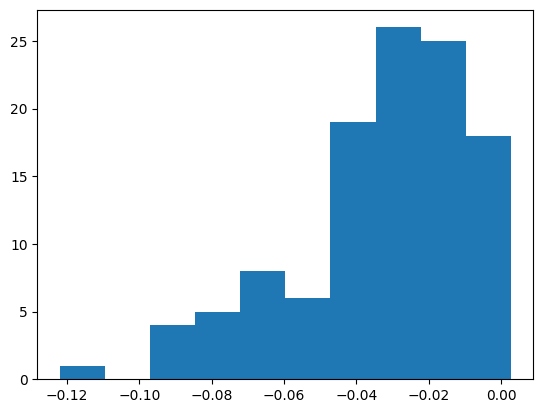

In [301]:
gsum = acleads[['COMID','total_decline']].groupby("COMID").mean()

plt.hist(gsum['total_decline'])

print(np.quantile(abs(gsum['total_decline']),0.9))


from scipy.stats import percentileofscore

value = 0.05
percentile = percentileofscore(abs(gsum['total_decline']), value, kind='rank')
percentile


gsum['total_decline'].median()

In [ ]:

npixels_onedecline = gsum[gsum.declined_both_leads.sort_values() <=1].num_pixels.sum()
print("Number of pixels only one decline:",npixels_onedecline)

npixels_onedecline = len(gsum[gsum.declined_both_leads.sort_values() >=1])
print("Number of lakes with no decline pixels:",npixels_onedecline)





AttributeError: 'DataFrame' object has no attribute 'declined_both_leads'

With accuracy, spec and sens

KeyboardInterrupt: 

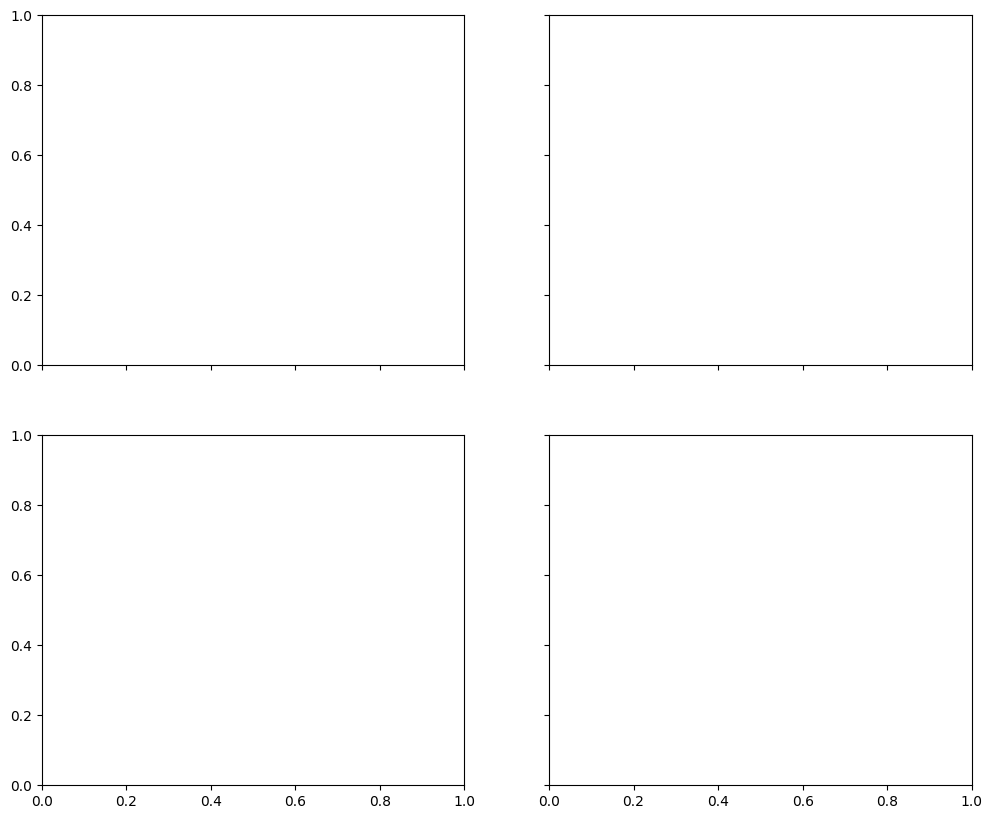

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

# Define file path and files
path = '/Users/mbeal/Library/CloudStorage/OneDrive-SharedLibraries-EnvironmentalProtectionAgency(EPA)/Science & Coffee - Beal_Atmos/'
files = [path+'RF_folds_all.csv', path+"BRMS_folds_all.csv", path+"CLSTM_folds_all.csv",path+'RF_folds_all.csv']
model_names = ['Random Forest', 'Bayesian MLR', 'ConvLSTM', "Long-term Average (Reference)"]

readcols = ['x', 'y', 'chl_predicted', 'chl_LTA', 'Week','error', 'chl_observed', 
            'Bloom_predicted','Bloom_observed','Bloom_LTA_al1','Time','Bloom_observed_al2',
            'Bloom_predicted_al2','Bloom_LTA_al1','Bloom_LTA_al2']


def annotate_with_halo(ax, x, y, text, **kwargs):
    txt = ax.text(x, y, text, **kwargs)
    txt.set_path_effects([
        path_effects.Stroke(linewidth=2, foreground='white'),
        path_effects.Normal()
    ])
    return txt

# Set up subplots
fig, axes = plt.subplots(2, 2, figsize=(12,10), sharex=True, sharey=True)
axes = axes.ravel()

def compute_classification_metrics(obs, pred, threshold):
    obs_binary = obs >= threshold
    pred_binary = pred >= threshold
    TP = np.sum((pred_binary == 1) & (obs_binary == 1))
    TN = np.sum((pred_binary == 0) & (obs_binary == 0))
    FP = np.sum((pred_binary == 1) & (obs_binary == 0))
    FN = np.sum((pred_binary == 0) & (obs_binary == 1))
    
    total = TP + TN + FP + FN
    accuracy = ((TP + TN) / total)*100 if total > 0 else np.nan
    sensitivity = (TP / (TP + FN))*100 if (TP + FN) > 0 else np.nan
    specificity = (TN / (TN + FP))*100 if (TN + FP) > 0 else np.nan
    
    return accuracy, sensitivity, specificity

for ax, file, model_name in zip(axes, files, model_names):
    # Load and clean data

    if model_name!="Long-term Average (Reference)":
        df1 = pd.read_csv(file, usecols=readcols).dropna()


        if model_name=="Bayesian MLR":
            df1['chl_predicted'] = np.log10(df1['chl_predicted'])
            df1 = df1[~np.isinf(df1['chl_predicted'])]

        df_valid = df1[(df1['chl_observed'] > 0) & (df1['chl_predicted'] > 0)].copy()



        # Compute regression metrics
        r2 = r2_score(df_valid['chl_observed'], df_valid['chl_predicted'])
        mae = mean_absolute_error(df_valid['chl_observed'], df_valid['chl_predicted'])

        # Compute classification metrics at 12 and 24 µg/L
        acc12, sens12, spec12 = compute_classification_metrics(df_valid['chl_observed'], df_valid['chl_predicted'], 12)
        acc24, sens24, spec24 = compute_classification_metrics(df_valid['chl_observed'], df_valid['chl_predicted'], 24)

        # Hexbin plot
        hb = ax.hexbin(
            df_valid['chl_observed'],
            df_valid['chl_predicted'],
            gridsize=300,
            cmap='GnBu_r',
            mincnt=1,
            bins='log'
        )

    else:
        df_valid = df1[(df1['chl_observed'] > 0) & (df1['chl_LTA'] > 0)].copy()
        # Compute regression metrics
        r2 = r2_score(df_valid['chl_observed'], df_valid['chl_LTA'])
        mae = mean_absolute_error(df_valid['chl_observed'], df_valid['chl_LTA'])
        # Compute classification metrics at 12 and 24 µg/L
        acc12, sens12, spec12 = compute_classification_metrics(df_valid['chl_observed'], df_valid['chl_LTA'], 12)
        acc24, sens24, spec24 = compute_classification_metrics(df_valid['chl_observed'], df_valid['chl_LTA'], 24)
        # Hexbin plot
        hb = ax.hexbin(
            df_valid['chl_observed'],
            df_valid['chl_LTA'],
            gridsize=300,
            cmap='GnBu_r',
            mincnt=1,
            bins='log'
        )

    # Add reference lines
    lims = [0, 300]
    ax.plot(lims, lims, 'r--', label='1:1 Line')
    for t in [12, 24]:
        ax.axhline(t, color='gray', linestyle=':')
        ax.axvline(t, color='gray', linestyle=':')

    # Set plot labels and title
    ax.set_title(model_name)
    ax.set_xlim(0, 300)
    ax.set_ylim(0, 300)

    # Annotate R2 and MAE
    annotate_with_halo(ax, 10, 285, 'Deterministic:', fontsize=9, color='black',fontweight='bold')
    annotate_with_halo(ax, 15, 275, f'R² = {r2:.3f}', fontsize=9, color='black')
    annotate_with_halo(ax, 15, 265, f'MAE = {mae:.2f}', fontsize=9, color='black')

    # Annotate classification metrics
    #ax.text(10, 250, f'Categorical AL1 (12 µgL⁻¹):', fontsize=9, fontweight='bold')
    #ax.text(15, 240, f'Acc: {acc12:.2f}  Sens: {sens12:.2f}  Spec: {spec12:.2f}', fontsize=9)
    annotate_with_halo(ax, 10, 250, f'Categorical AL1 (12 µgL⁻¹):', fontsize=9, color='black', fontweight='bold')
    annotate_with_halo(ax, 15, 240, f'Acc: {acc12:.1f}  Sens: {sens12:.1f}  Spec: {spec12:.1f}', color='black', fontsize=9)


    #ax.text(10, 220, f'Categorical AL2 (24 µgL⁻¹):', fontsize=9, fontweight='bold')
    #ax.text(15, 210, f'Acc: {acc24:.2f}  Sens: {sens24:.2f}  Spec: {spec24:.2f}', fontsize=9)
    annotate_with_halo(ax,10, 220, f'Categorical AL2 (24 µgL⁻¹):', fontsize=9, color='black', fontweight='bold')
    annotate_with_halo(ax,15, 210, f'Acc: {acc24:.1f}  Sens: {sens24:.1f}  Spec: {spec24:.1f}', color='black', fontsize=9)



# Shared axis labels
fig.text(0.5, 0.04, 'Observed Chlorophyll (µgL⁻¹)', ha='center', fontsize=12)
fig.text(0.06, 0.5, 'Predicted Chlorophyll (µgL⁻¹)', va='center', rotation='vertical', fontsize=12)

# Colorbar
cbar = fig.colorbar(hb, ax=axes.ravel().tolist(), label='log10(N)')
plt.savefig('chlorophyll_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Compute regression metrics
r2 = r2_score(df_valid['chl_observed'], df_valid['chl_predicted'])
mae = mean_absolute_error(df_valid['chl_observed'], df_valid['chl_predicted'])

# Compute classification metrics at 12 and 24 µg/L
acc12, sens12, spec12 = compute_classification_metrics(df_valid['chl_observed'], df_valid['chl_predicted'], 12)
acc24, sens24, spec24 = compute_classification_metrics(df_valid['chl_observed'], df_valid['chl_predicted'], 24)
